# M-Lab Data Analysis Notebook

An autonomous system number (ASN) is a unique number assigned to an autonomous system(AS) by the Internet Assigned Numbers Authority (IANA).

An AS consists of blocks of IP addresses which have a distinctly defined policy for accessing external networks and are administered by a single organization but may be made up of several operators.

IPs of Starlink User Terminals have the ASN of `14593`

Also see:
- https://www.peeringdb.com/net/18747
- https://www.measurementlab.net/data/


I currently am using the [BigQuery interface](https://console.cloud.google.com/bigquery?project=measurement-lab&pli=1) to get the M-Lab data. The query result are then downloaded to the `./data/mlab_starlink_data` folder as a .csv file and used by the following scripts. The `./data/mlab_starlink_data/README.md` stores the used queries.

---

**Why not use the API?**

Because of this ([source](https://www.measurementlab.net/data/docs/bq/quickstart/)):

> [...] Because of the means by which M-Lab must whitelist query users, we cannot guarantee that no charges will be incurred by applications using service accounts which query M-Lab datasets, tables, and views.

**Retrieving the mlab data**

```bash
cd /path/to/this/notebook
cd data
wget https://syncandshare.lrz.de/dl/fiXT6TrDAYGGsK6To7v75K/mlab_starlink_data.zip
unzip mlab_starlink_data.zip
```

In [255]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import geohash
import cartopy.crs as ccrs
from datetime import datetime

In [256]:
# Starlink Availability scraped from wikipedia

from bs4 import BeautifulSoup
import requests

response = requests.get("https://en.wikipedia.org/wiki/Starlink")
soup = BeautifulSoup(response.text)

countries_soup = soup.find_all("table", attrs={"class": "wikitable"})[1]

countries = []
for a in countries_soup.find_all("tr")[1:]:
    for b in a.find_all("td")[2].find_all("a"):
        countries.append(b.text)

## Monthly Probe Count

In [257]:
ndt7_df = pd.read_csv("./data/mlab_starlink_data/ndt7_tableentrystats.csv").set_index("month")
starlink_launchdates = pd.read_csv("./data/starlink_launchdates.csv")
starlink_launchdates["LaunchDate"] = starlink_launchdates["LaunchDate"].apply(lambda datestr: pd.to_datetime(datestr, format="%Y-%m-%d"))

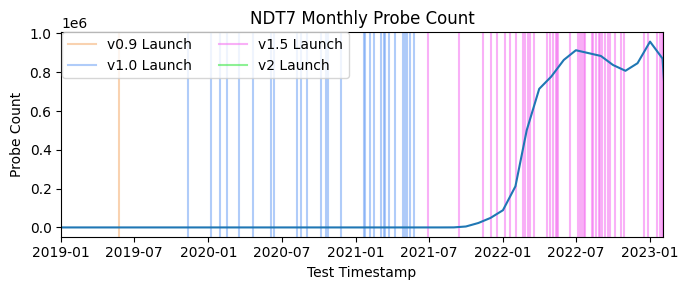

In [259]:
fig, ax = plt.subplots(figsize=(7, 3))
ax.plot(
    [datetime.fromisoformat(dt) for dt in ndt7_df.index],
    ndt7_df["entry_count"]
)
ax.set_xlim(
    datetime.fromisoformat(ndt7_df.index[0]),
    datetime.fromisoformat(ndt7_df.index[-2])
)

def extract_rev_dates(rev):
    return [a for _, a in starlink_launchdates[starlink_launchdates["Revision"] == rev]["LaunchDate"].items()]
def plot_dates(dates, color, label):
    for d in dates:
        ax.axvline(d,
                   color = color, label = label, zorder=1)
        label = ""
    
plot_dates(extract_rev_dates("v0.9"), color = "#f5ac6c88", label = "v0.9 Launch")
plot_dates(extract_rev_dates("v1.0"), color = "#6ca0f588", label = "v1.0 Launch")
plot_dates(extract_rev_dates("v1.5"), color = "#f56cf088", label = "v1.5 Launch")
plot_dates(extract_rev_dates("v2-Mini"), color = "#2ce63888", label = "v2 Launch")

plt.legend(loc='upper left', bbox_to_anchor=(-0.01, 1.035),
          ncol=2, fancybox=True, shadow=False)
    
ax.set_ylabel("Probe Count")
ax.set_xlabel("Test Timestamp")
plt.title("NDT7 Monthly Probe Count")
plt.tight_layout()
#plt.show()
#plt.savefig('tessstttyyy.png', dpi=300)
plt.savefig("figures/mlab_probecount_withlaunch.pdf")
plt.show()

## Cities Overview

In [260]:
import geohash
import geopandas
import pandas as pd
import numpy as np
import cartopy.crs as ccrs
from matplotlib import colors
from descartes import PolygonPatch

In [261]:
ndt7_df   = pd.read_csv("./data/mlab_starlink_data/ndt7_cities_overview.csv").set_index("ClientGeohash")
ndt7_df = ndt7_df.sort_values(by="MeasurementCount", ascending=False)
ndt7_df["lat"] = [geohash.decode(gh)[0] for gh in ndt7_df.index]
ndt7_df["lon"] = [geohash.decode(gh)[1] for gh in ndt7_df.index]

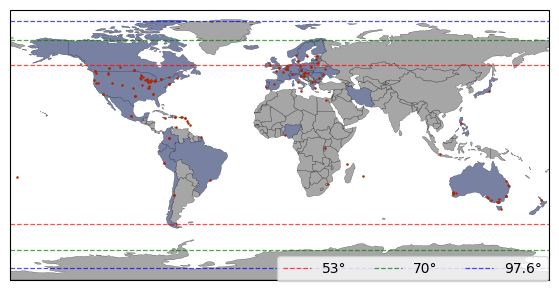

In [338]:
continents = ["AF", "AS", "EU", "NA", "OC", "SA"]
cols = ["#c1d5e2", "#ce9c7f", "#7598b6", "#6a7465", "#914c09", "#663979", "#fbe17b"]

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
#world = world[(world.name!="Antarctica")]

def plotCountryPatch( axes, country_name, fcolor ):
    # plot a country on the provided axes
    nami = world[world.name == country_name]
    namigm = nami.__geo_interface__['features']  # geopandas's geo_interface
    namig0 = {'type': namigm[0]['geometry']['type'], \
              'coordinates': namigm[0]['geometry']['coordinates']}
    axes.add_patch(PolygonPatch( namig0, fc=fcolor, ec="black", alpha=0.4, zorder=2, linewidth=0.0 ))


fig, ax = plt.subplots(figsize=(7, 3), subplot_kw={'projection': ccrs.PlateCarree()})

cmap = colors.ListedColormap(cols[:-2])
world.plot(facecolor = "grey", edgecolor="black", ax=ax, linewidth=0.2, alpha=0.7, zorder=0)

for c in countries:
    c = "United States of America" if c == "United States" else c
    c = "Czechia" if c == "Czech Republic" else c
    
    if(c in world["name"].values):
        plotCountryPatch(ax, c, "#364aa0")
    #else:
    #    print(c)

def plot_extent(inclination, color="r", lw=0.9, alpha=0.7):
    label = "{}°".format(inclination)
    if inclination > 90:
        inclination = 90 - (inclination % 90)
    plt.plot([-180, 180], [ inclination,  inclination], linewidth=lw, color=color, linestyle="dashed", alpha=alpha, label=label)
    plt.plot([-180, 180], [-inclination, -inclination], linewidth=lw, color=color, linestyle="dashed", alpha=alpha)

plot_extent(53, "r")
plot_extent(70, "g")
plot_extent(97.6, "b")

#for x, y, label in zip(ndt7_df["lon"], ndt7_df["lat"], ndt7_df["ClientCountry"]):
#    ax.annotate(
#                    label,
#                    xy=(x, y),
#                    xytext=(2, 2),
#                    textcoords="offset points",
#                    fontsize=5
#    )
        
latitude, longitude = ndt7_df["lat"], ndt7_df["lon"]
ax.scatter(longitude, latitude, 
               sizes = [0.7],
               color="#a8290a",
               zorder = 10)

plt.legend(loc='lower right', bbox_to_anchor=(1.01, -0.03),
          ncol=3, fancybox=True, shadow=False)

ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])

plt.tight_layout()
plt.savefig("figures/cities_overview_map.pdf")
plt.show()

In [263]:
# Countries Outside of 53° latitude region. However: no probe is from outside of 53° coverage
ndt7_df[ndt7_df["lat"] > 53]["ClientCountry"]

ClientGeohash
gc7x3      Ireland
gc7x3      Ireland
u4xst       Norway
u6sce       Sweden
u3buy      Denmark
ud9d4      Estonia
ud15u       Latvia
u9dp0    Lithuania
u3buw      Denmark
u99zp    Lithuania
ud9d4      Estonia
Name: ClientCountry, dtype: object

## 5 City Overview

- Seattle
- Oslo
- Mexico City
- Bogotá
- Sydney

### Over entire Time Range

In [467]:
df = pd.read_csv("./data/mlab_starlink_data/ndt7_city_filtered1.csv", 
                 usecols = ["a_TestTime", "a_CongestionControl", "a_MeanThroughputMbps", "a_MinRTT", "a_LossRate", 
                            "server_Site",
                            "client_Geo_City", "client_Geo_Latitude", "client_Geo_Longitude", "client_Geo_AccuracyRadiusKm",
                            "raw_ServerIP", "raw_ClientIP"]
                )

In [468]:
# Filtering / Transforming of values
df = df[df["a_MinRTT"] < 2000] # Discarding outliers. Arbitrary chosen limit of 2000 ms
df["a_TestTime"] = df["a_TestTime"].apply(lambda datestr: datetime.strptime(datestr, '%Y-%m-%d %H:%M:%S.%f %Z'))
df["a_TestMonth"] = df["a_TestTime"].apply(lambda date: datetime(year=date.year, month=date.month, day = 1))

coordinates_df = df[["client_Geo_City", "client_Geo_Latitude", "client_Geo_Longitude"]].drop_duplicates()
coordinates_df = coordinates_df.groupby(["client_Geo_City"]).mean()

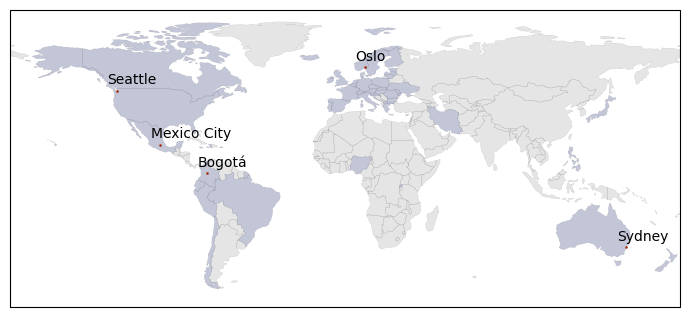

In [469]:
cols = ["#c1d5e2", "#ce9c7f", "#7598b6", "#6a7465", "#914c09", "#663979", "#fbe17b"]

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world = world[(world.name!="Antarctica")]

def plotCountryPatch( axes, country_name, fcolor ):
    # plot a country on the provided axes
    nami = world[world.name == country_name]
    namigm = nami.__geo_interface__['features']  # geopandas's geo_interface
    namig0 = {'type': namigm[0]['geometry']['type'], \
              'coordinates': namigm[0]['geometry']['coordinates']}
    axes.add_patch(PolygonPatch( namig0, fc=fcolor, ec="black", alpha=0.2, zorder=2, linewidth=0.0 ))


fig, ax = plt.subplots(figsize=(7, 6), subplot_kw={'projection': ccrs.PlateCarree()})

cmap = colors.ListedColormap(cols[:-2])
world.plot(facecolor = "grey", edgecolor="black", ax=ax, linewidth=0.2, alpha=0.2, zorder=0)

for c in countries:
    c = "United States of America" if c == "United States" else c
    c = "Czechia" if c == "Czech Republic" else c
    
    if(c in world["name"].values):
        plotCountryPatch(ax, c, "#364aa088")
        
latitude, longitude = coordinates_df["client_Geo_Latitude"], coordinates_df["client_Geo_Longitude"]
ax.scatter(longitude, latitude, 
               sizes = [0.7],
               color="#a8290a",
               zorder = 10)

for x, y, label in zip(coordinates_df["client_Geo_Longitude"], coordinates_df["client_Geo_Latitude"], coordinates_df.index):
    ax.annotate(label, xy=(x, y), xytext=(-7, 5), textcoords="offset points")

ax.set_extent([-180, 180, -65, 90], ccrs.PlateCarree())
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])

plt.tight_layout()
plt.savefig("figures/5cities_map.pdf", pad_inches=0)
plt.show()

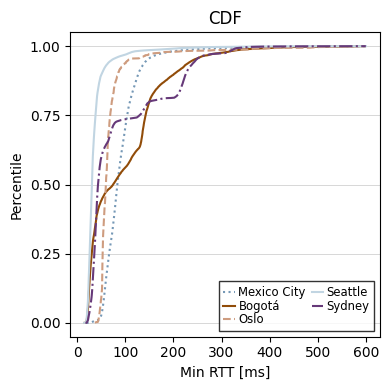

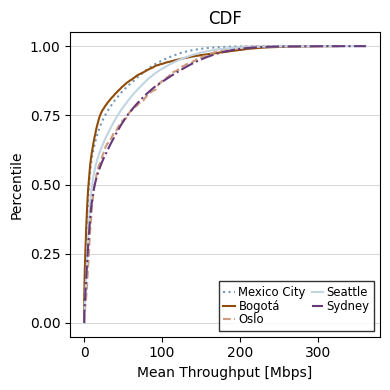

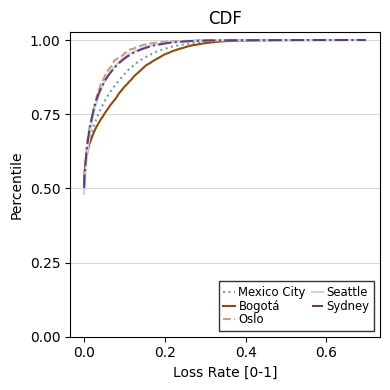

In [470]:
interesting_cities = [
                "Mexico City",
                "Bogotá",
                "Oslo",
                "Seattle",
                "Sydney"]

city_colors = {
            "Mexico City" : "#7598b6",
            "Bogotá"      : "#914c09",
            "Oslo"        : "#ce9c7f",
            "Seattle"     : "#c1d5e2", 
            "Sydney"      : "#663979"
                }
lstyles = {
            "Mexico City" : "dotted",
            "Bogotá"      : "solid",
            "Oslo"        : "dashed",
            "Seattle"     : "solid", 
            "Sydney"      : "dashdot"
                }

def plot_cdf(df, cities, column, xlabel, figsize=(7, 4), savefig="", title="CDF", city_colors=city_colors, lstyles=lstyles, condition=True):
    fig, ax = plt.subplots(figsize=figsize)
    for city in cities:
        #  & (df["a_MinRTT"] < 600)
        xs = df[(df["client_Geo_City"] == city) & (condition)][column].values
        xs = sorted(xs)
        ys = np.arange(1, len(xs) + 1) / len(xs)
        indices = []
        current = xs[0]
        for i, x in enumerate(xs): # only take max y value at each x value to smoothen out the graph
            if x != current:
                current = x
                indices.append(i - 1)
        indices.append(len(ys) - 1)
        xs = sorted(set(xs))
        ys = [ys[i] for i in indices]
        ax.plot(xs, ys, label=city, color=city_colors[city], linestyle=lstyles[city])

    ax.set_xlabel(xlabel)
    ax.set_ylabel("Percentile")
    ax.set_yticks(np.arange(0, 1.25, 0.25))
    ax.xaxis.get_major_formatter()._usetex = False
    ax.yaxis.get_major_formatter()._usetex = False

    ax.legend(loc="lower right", fontsize="small", ncol=2, edgecolor="k", handlelength=1, labelspacing=0.06,
              columnspacing=0.5, handletextpad=0.3, fancybox=False)
    plt.grid(True, axis='y', linestyle='-', alpha=0.7, linewidth=0.5)

    plt.title(title)
    fig.tight_layout()
    if(savefig != ""):
        plt.savefig(savefig, pad_inches = 0)
    plt.show()

plot_cdf(df, interesting_cities, "a_MinRTT", "Min RTT [ms]", figsize=(4,4), condition=df["a_MinRTT"] < 600, savefig="cdf_minrtt_5cities.pdf")
plot_cdf(df, interesting_cities, "a_MeanThroughputMbps", "Mean Throughput [Mbps]", figsize=(4,4), savefig="cdf_meanthroughput_5cities.pdf")
plot_cdf(df, interesting_cities, "a_LossRate", "Loss Rate [0-1]", figsize=(4,4), savefig="cdf_lossrate_5cities.pdf")

### Time Sensitive

In [368]:
comparison_df = pd.DataFrame()
comparison_df["OverallCount"] = df.groupby("client_Geo_City")["a_TestTime"].count()
comparison_df["OverallPreOctober"] = df[df["a_TestTime"] < datetime(year=2022, month=10, day=1)].groupby("client_Geo_City")["a_TestTime"].count()
comparison_df["OverallPostOctober"] = df[df["a_TestTime"] > datetime(year=2022, month=10, day=1)].groupby("client_Geo_City")["a_TestTime"].count()
comparison_df

,OverallCount,OverallPreOctober,OverallPostOctober
client_Geo_City,,,
Bogotá,13789,268,13521
Mexico City,274213,73195,201018
Oslo,1251,72,1179
Seattle,1221194,763675,457519
Sydney,666479,263911,402568


In [452]:
# Grouping per Month
month_grouped = df.groupby(["client_Geo_City", "a_TestMonth"]).count()[["a_TestTime"]]
month_grouped = month_grouped.rename(columns={"a_TestTime": "ProbeCount"})
month_grouped["MeanMinRTT"] = df.groupby(["client_Geo_City", "a_TestMonth"]).mean(numeric_only=True)["a_MinRTT"]
month_grouped["MeanThroughputMbps"] = df.groupby(["client_Geo_City", "a_TestMonth"]).mean(numeric_only=True)["a_MeanThroughputMbps"]
month_grouped["MeanLossRate"] = df.groupby(["client_Geo_City", "a_TestMonth"]).mean(numeric_only=True)["a_LossRate"]
month_grouped = month_grouped.reset_index()

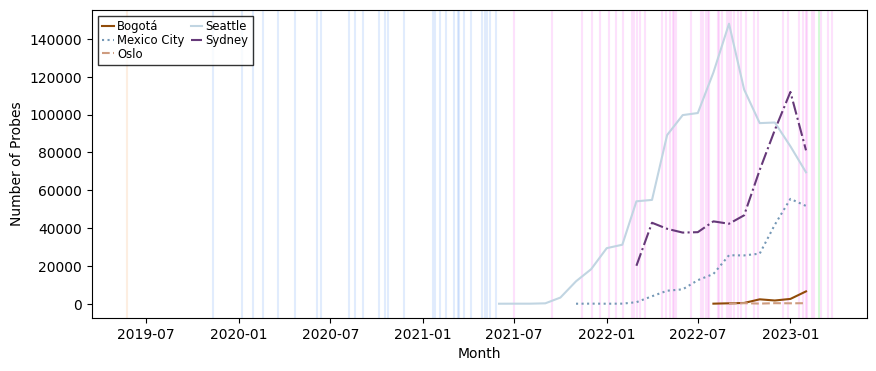

In [471]:
# Compaing Monthly amount of probes for each city
selected_cities = comparison_df.index

def extract_rev_dates(rev):
    return [a for _, a in starlink_launchdates[starlink_launchdates["Revision"] == rev]["LaunchDate"].items()]
def plot_dates(dates, color, label):
    for d in dates:
        ax.axvline(d,
                   color = color, label = label, zorder=1)
        label = ""

fig, ax = plt.subplots(figsize=(10, 4))

plot_dates(extract_rev_dates("v0.9"), color = "#f5ac6c33", label="")
plot_dates(extract_rev_dates("v1.0"), color = "#6ca0f533", label="")
plot_dates(extract_rev_dates("v1.5"), color = "#f56cf033", label="")
plot_dates(extract_rev_dates("v2-Mini"), color = "#2ce63833", label="")

for city in selected_cities:
    temp_df = month_grouped[month_grouped["client_Geo_City"] == city].sort_values("a_TestMonth")
    ax.plot(temp_df["a_TestMonth"], temp_df["ProbeCount"], label=city, color=continent_colors[city], linestyle=lstyles[city])

ax.set_xlabel("Month")
ax.set_ylabel("Number of Probes")
ax.legend(loc="upper left", fontsize="small", ncol=2, edgecolor="k", handlelength=1, labelspacing=0.06,
          columnspacing=0.5, handletextpad=0.3, fancybox=False)

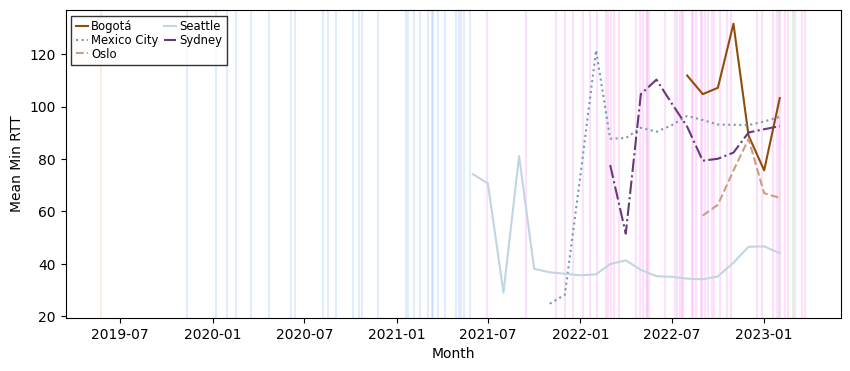

In [472]:
fig, ax = plt.subplots(figsize=(10, 4))

plot_dates(extract_rev_dates("v0.9"), color = "#f5ac6c33", label="")
plot_dates(extract_rev_dates("v1.0"), color = "#6ca0f533", label="")
plot_dates(extract_rev_dates("v1.5"), color = "#f56cf033", label="")
plot_dates(extract_rev_dates("v2-Mini"), color = "#2ce63833", label="")

for city in selected_cities:
    temp_df = month_grouped[month_grouped["client_Geo_City"] == city].sort_values("a_TestMonth")
    ax.plot(temp_df["a_TestMonth"], temp_df["MeanMinRTT"], label=city, color=continent_colors[city], linestyle=lstyles[city])

ax.set_xlabel("Month")
ax.set_ylabel("Mean Min RTT")
ax.legend(loc="upper left", fontsize="small", ncol=2, edgecolor="k", handlelength=1, labelspacing=0.06,
          columnspacing=0.5, handletextpad=0.3, fancybox=False)

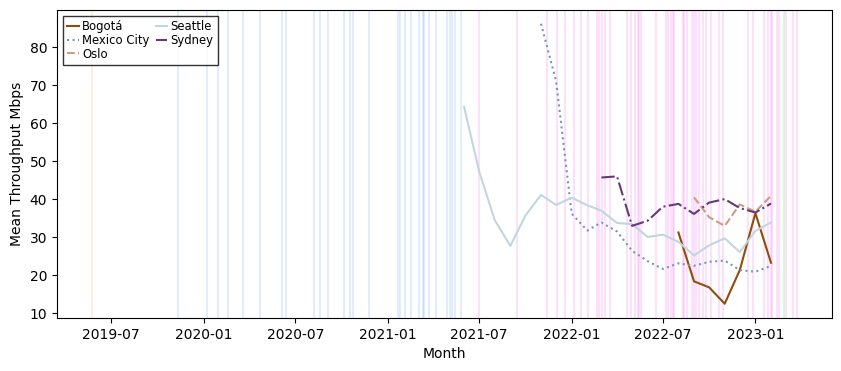

In [474]:
fig, ax = plt.subplots(figsize=(10, 4))

plot_dates(extract_rev_dates("v0.9"), color = "#f5ac6c33", label="")
plot_dates(extract_rev_dates("v1.0"), color = "#6ca0f533", label="")
plot_dates(extract_rev_dates("v1.5"), color = "#f56cf033", label="")
plot_dates(extract_rev_dates("v2-Mini"), color = "#2ce63833", label="")

for city in selected_cities:
    temp_df = month_grouped[month_grouped["client_Geo_City"] == city].sort_values("a_TestMonth")
    ax.plot(temp_df["a_TestMonth"], temp_df["MeanThroughputMbps"], label=city, color=continent_colors[city], linestyle=lstyles[city])

ax.set_xlabel("Month")
ax.set_ylabel("Mean Throughput Mbps")
ax.legend(loc="upper left", fontsize="small", ncol=2, edgecolor="k", handlelength=1, labelspacing=0.06,
          columnspacing=0.5, handletextpad=0.3, fancybox=False)
plt.savefig("temp.png", dpi=300)

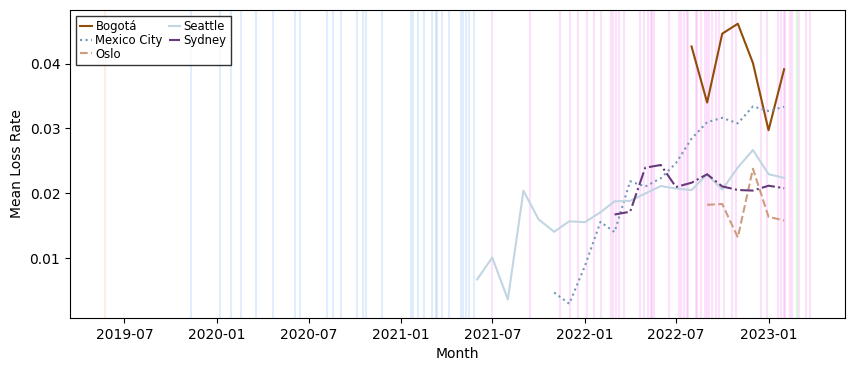

In [456]:
fig, ax = plt.subplots(figsize=(10, 4))

plot_dates(extract_rev_dates("v0.9"), color = "#f5ac6c33", label="")
plot_dates(extract_rev_dates("v1.0"), color = "#6ca0f533", label="")
plot_dates(extract_rev_dates("v1.5"), color = "#f56cf033", label="")
plot_dates(extract_rev_dates("v2-Mini"), color = "#2ce63833", label="")

for city in selected_cities:
    temp_df = month_grouped[month_grouped["client_Geo_City"] == city].sort_values("a_TestMonth")
    ax.plot(temp_df["a_TestMonth"], temp_df["MeanLossRate"], label=city, color=continent_colors[city], linestyle=lstyles[city])

ax.set_xlabel("Month")
ax.set_ylabel("Mean Loss Rate")
ax.legend(loc="upper left", fontsize="small", ncol=2, edgecolor="k", handlelength=1, labelspacing=0.06,
          columnspacing=0.5, handletextpad=0.3, fancybox=False)

## 5 US Cities

In [459]:
df = pd.read_csv("./data/mlab_starlink_data/ndt7_city_filtered3.csv")

In [461]:
# Filtering / Transforming of values
df = df[df["a_MinRTT"] < 2000] # Discarding outliers. Arbitrary chosen limit of 2000 ms
def convert_date(datestr):
    try:
        return datetime.strptime(datestr, '%Y-%m-%d %H:%M:%S.%f %Z')
    except ValueError:
        return datetime.strptime(datestr, '%Y-%m-%d %H:%M:%S %Z')
df["a_TestTime"] = df["a_TestTime"].apply(convert_date)
df["a_TestMonth"] = df["a_TestTime"].apply(lambda date: datetime(year=date.year, month=date.month, day = 1))

coordinates_df = df[["client_Geo_City", "client_Geo_Latitude", "client_Geo_Longitude"]].drop_duplicates()
coordinates_df = coordinates_df.groupby(["client_Geo_City"]).mean()

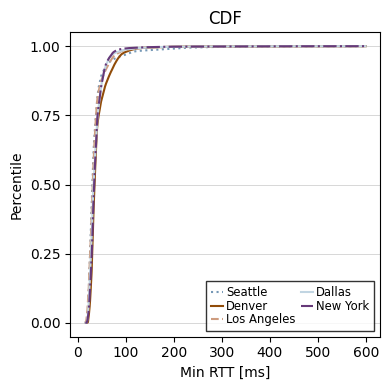

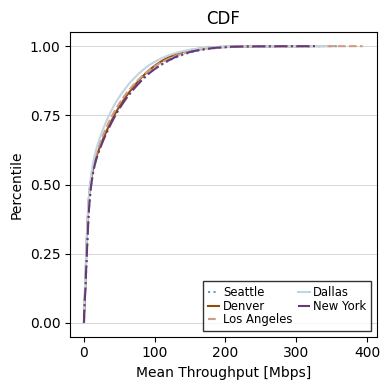

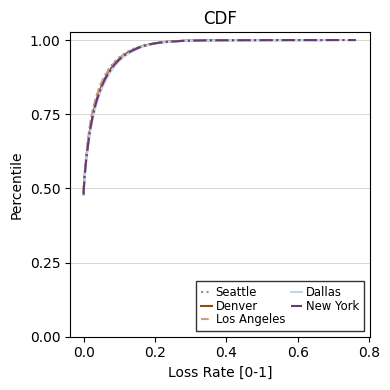

In [465]:
interesting_cities = [
                "Seattle",
                "Denver",
                "Los Angeles",
                "Dallas",
                "New York"]

city_colors = {
            "Seattle"     : "#7598b6",
            "Denver"      : "#914c09",
            "Los Angeles" : "#ce9c7f",
            "Dallas"      : "#c1d5e2", 
            "New York"    : "#663979"
                }
lstyles = {
            "Seattle"     : "dotted",
            "Denver"      : "solid",
            "Los Angeles" : "dashed",
            "Dallas"      : "solid", 
            "New York"    : "dashdot"
                }

def plot_cdf(df, cities, column, xlabel, figsize=(7, 4), savefig="", title="CDF", city_colors=city_colors, lstyles=lstyles, condition=True):
    fig, ax = plt.subplots(figsize=figsize)
    for city in cities:
        #  & (df["a_MinRTT"] < 600)
        xs = df[(df["client_Geo_City"] == city) & (condition)][column].values
        xs = sorted(xs)
        ys = np.arange(1, len(xs) + 1) / len(xs)
        indices = []
        current = xs[0]
        for i, x in enumerate(xs): # only take max y value at each x value to smoothen out the graph
            if x != current:
                current = x
                indices.append(i - 1)
        indices.append(len(ys) - 1)
        xs = sorted(set(xs))
        ys = [ys[i] for i in indices]
        ax.plot(xs, ys, label=city, color=city_colors[city], linestyle=lstyles[city])

    ax.set_xlabel(xlabel)
    ax.set_ylabel("Percentile")
    ax.set_yticks(np.arange(0, 1.25, 0.25))
    ax.xaxis.get_major_formatter()._usetex = False
    ax.yaxis.get_major_formatter()._usetex = False

    ax.legend(loc="lower right", fontsize="small", ncol=2, edgecolor="k", handlelength=1, labelspacing=0.06,
              columnspacing=0.5, handletextpad=0.3, fancybox=False)
    plt.grid(True, axis='y', linestyle='-', alpha=0.7, linewidth=0.5)

    plt.title(title)
    fig.tight_layout()
    if(savefig != ""):
        plt.savefig(savefig, pad_inches = 0)
    plt.show()

plot_cdf(df, interesting_cities, "a_MinRTT", "Min RTT [ms]", figsize=(4,4), condition=df["a_MinRTT"] < 600, savefig="figures/cdf_minrtt_5uscities.pdf")
plot_cdf(df, interesting_cities, "a_MeanThroughputMbps", "Mean Throughput [Mbps]", figsize=(4,4), savefig="figures/cdf_meanthroughput_5uscities.pdf")
plot_cdf(df, interesting_cities, "a_LossRate", "Loss Rate [0-1]", figsize=(4,4), savefig="figures/cdf_lossrate_5uscities.pdf")

## 5 South American Cities

In [475]:
df = pd.read_csv("./data/mlab_starlink_data/ndt7_city_filtered4.csv")

In [476]:
# Filtering / Transforming of values
df = df[df["a_MinRTT"] < 2000] # Discarding outliers. Arbitrary chosen limit of 2000 ms
def convert_date(datestr):
    try:
        return datetime.strptime(datestr, '%Y-%m-%d %H:%M:%S.%f %Z')
    except ValueError:
        return datetime.strptime(datestr, '%Y-%m-%d %H:%M:%S %Z')
df["a_TestTime"] = df["a_TestTime"].apply(convert_date)
df["a_TestMonth"] = df["a_TestTime"].apply(lambda date: datetime(year=date.year, month=date.month, day = 1))

coordinates_df = df[["client_Geo_City", "client_Geo_Latitude", "client_Geo_Longitude"]].drop_duplicates()
coordinates_df = coordinates_df.groupby(["client_Geo_City"]).mean()

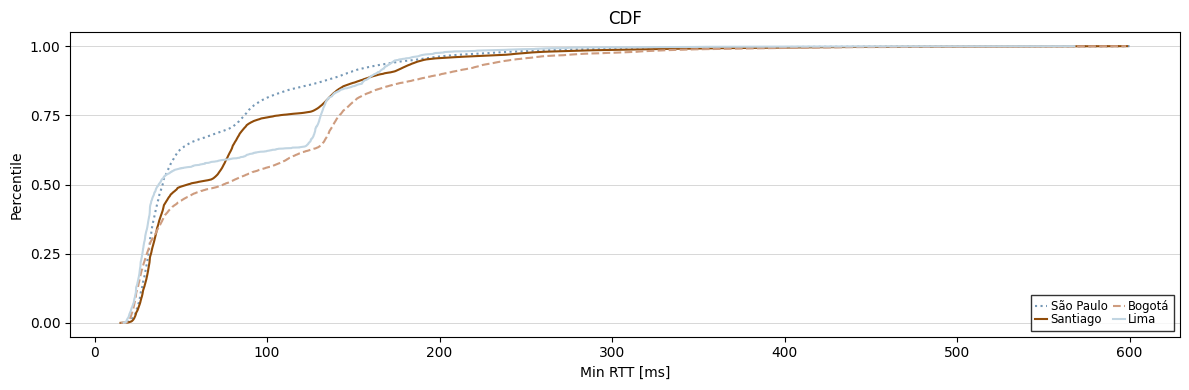

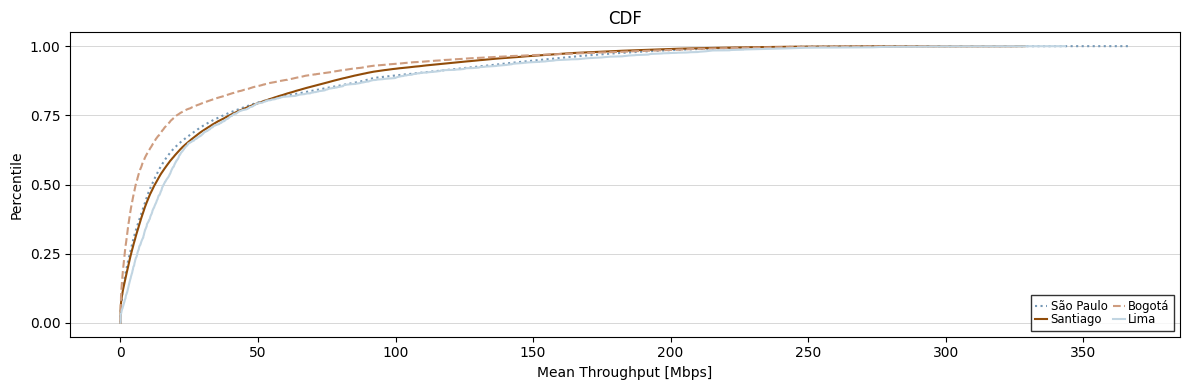

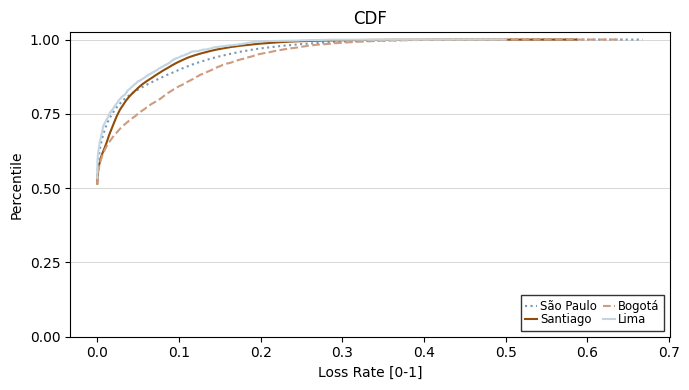

In [481]:
interesting_cities = [
                "São Paulo",
                "Santiago",
                "Bogotá",
                "Lima"]

city_colors = {
            "São Paulo"  : "#7598b6",
            "Santiago"   : "#914c09",
            "Bogotá"     : "#ce9c7f",
            "Lima"       : "#c1d5e2", 
            "Nuku'alofa" : "#663979"
                }
lstyles = {
            "São Paulo"  : "dotted",
            "Santiago"   : "solid",
            "Bogotá"     : "dashed",
            "Lima"       : "solid", 
            "Nuku'alofa" : "dashdot"
                }

def plot_cdf(df, cities, column, xlabel, figsize=(7, 4), savefig="", title="CDF", city_colors=city_colors, lstyles=lstyles, condition=True):
    fig, ax = plt.subplots(figsize=figsize)
    for city in cities:
        #  & (df["a_MinRTT"] < 600)
        xs = df[(df["client_Geo_City"] == city) & (condition)][column].values
        xs = sorted(xs)
        ys = np.arange(1, len(xs) + 1) / len(xs)
        indices = []
        current = xs[0]
        for i, x in enumerate(xs): # only take max y value at each x value to smoothen out the graph
            if x != current:
                current = x
                indices.append(i - 1)
        indices.append(len(ys) - 1)
        xs = sorted(set(xs))
        ys = [ys[i] for i in indices]
        ax.plot(xs, ys, label=city, color=city_colors[city], linestyle=lstyles[city])

    ax.set_xlabel(xlabel)
    ax.set_ylabel("Percentile")
    ax.set_yticks(np.arange(0, 1.25, 0.25))
    ax.xaxis.get_major_formatter()._usetex = False
    ax.yaxis.get_major_formatter()._usetex = False

    ax.legend(loc="lower right", fontsize="small", ncol=2, edgecolor="k", handlelength=1, labelspacing=0.06,
              columnspacing=0.5, handletextpad=0.3, fancybox=False)
    plt.grid(True, axis='y', linestyle='-', alpha=0.7, linewidth=0.5)

    plt.title(title)
    fig.tight_layout()
    if(savefig != ""):
        plt.savefig(savefig, pad_inches = 0)
    plt.show()

plot_cdf(df, interesting_cities, "a_MinRTT", "Min RTT [ms]", figsize=(12,4), condition=df["a_MinRTT"] < 600, savefig="cdf_minrtt_5sacities.pdf")
plot_cdf(df, interesting_cities, "a_MeanThroughputMbps", "Mean Throughput [Mbps]", figsize=(12,4), savefig="cdf_meanthroughput_5sacities.pdf")
plot_cdf(df, interesting_cities, "a_LossRate", "Loss Rate [0-1]", figsize=(7,4), savefig="cdf_lossrate_5sacities.pdf")

## Boxplots

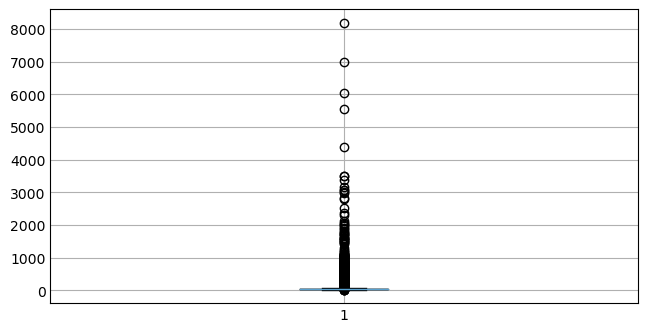

In [4]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('_mpl-gallery')

# make data:
#np.random.seed(10)
#arr1 = np.random.normal(5, 1, size=(10,))
#arr2 = np.random.normal(3, 3, size=(10,))
#arr3 = np.random.normal(10, 0.3, size=(10,))
#arr4 = np.random.normal(4, 5, size=(10,))

#columns = [
#    df[df["ClientCity"] == "Mexico City"]["MinRTT"],
#    df[df["ClientCity"] == "Bogotá"]["MinRTT"],
#    df[df["ClientCity"] == "Oslo"]["MinRTT"],
#    df[df["ClientCity"] == "Seattle"]["MinRTT"],
#    df[df["ClientCity"] == "Sydney"]["MinRTT"]
#]

columns = [df[(df["ClientCity"] == "Berlin") & (df["MinRTT"] < 100000)]["MinRTT"]]

fig, ax = plt.subplots(figsize=(6, 3))
ax.boxplot(columns)
plt.show()

In [7]:
def row2box(row, attr, usestd = True):
    median = row["{}_q2".format(attr)]
    
    if(usestd):
        q0 = median - row["{}_stddev".format(attr)]
        q0 = 0 if q0 < 0 else q0
        q4 = median + row["{}_stddev".format(attr)]
    else:
        q0 = row["{}_q0".format(attr)]
        q0 = 0 if q0 < 0 else q0
        q4 = row["{}_q4".format(attr)]
        q4 = row["{}_q3".format(attr)]
    
    return {
        'label' : row.name,
        'whislo': q0,# Bottom whisker position
        'q1'    : row["{}_q1".format(attr)],             # First quartile (25th percentile)
        'med'   : median,                                # Median         (50th percentile)
        'q3'    : row["{}_q3".format(attr)],             # Third quartile (75th percentile)
        'whishi': q4,    # Top whisker position
        'fliers': []                                     # Outliers
    }

def visualize_boxplot(df, attr, save=False, usestd=True):
    fig, ax = plt.subplots(figsize=(6, 3))
    boxes = [row2box(row, attr, usestd=usestd) for idx, row in df.iterrows()]
    ax.bxp(boxes, showfliers=False)
    
    if(attr == "MeanThroughputMbps"):
        ax.set_ylabel("Mean Throughput in Mbps")
    elif(attr == "MinRTT"):
        ax.set_ylabel("Min RTT in milliseconds")
    elif(attr == "lossrate"):
        ax.set_ylabel("Lossrate from the lifetime of the connection")
    
    if(save):
        plt.tight_layout()
        plt.savefig("mlab_{}_starlink_boxplot.pdf".format(attr))
    plt.show()
    
    
# [x] Filter Edge-Cases:
    # MinRTT = -1
    # Meanthroughput = 0.0
    # lossrate = -1
# [ ] Inverstigate Max value, put those into outliers
    # Maximum values are probably better in a spearate plot
# TODO: [x] Use Standard Deviation instead of Maximum/Minimum
# [ ] Compare throughput latencies reported over Cellular Networks with the ones over Starlink
    # https://github.com/tkdang97/Cloudy-with-a-Chance-of-Short-RTTs/blob/main/speedchecker-analysis.ipynb
    # Associated Dataset
        # Compare ISPs by looking at probes that connect to the same endpoint
            # Throughput, Latency/RTT
        # Use above information to compare the ISP to Starlink
# [ ] Sync Throughput Count Map with availability
# 


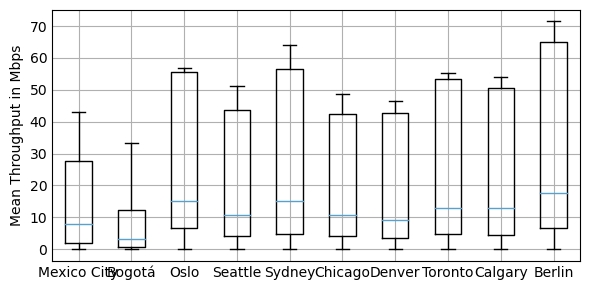

In [8]:
visualize_boxplot(df, "MeanThroughputMbps", save=True)

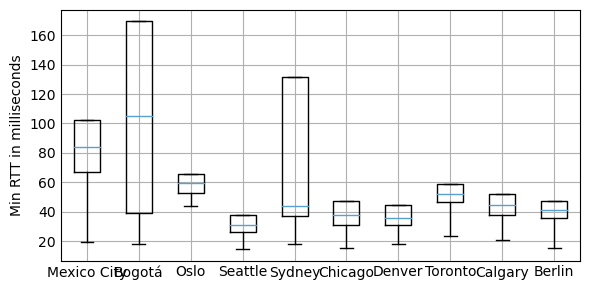

In [11]:
# This might be a bit interesting as CDF
#   - 75th percentile being lower than others 25th percentile
#   - long tail, from 75th percentile to max, there are interesting things going on

# Sydney vs. Seattle
#   - Satellite Density
#   - Gateway Distribution
#   - Groundstation Availability

# 2019 - 2022
visualize_boxplot(df, "MinRTT", save=True, usestd=False)

In [12]:
# 2019 - 2022
df["measurement_count"].sum()

3668876

In [13]:
# 2021 - 2022
df["measurement_count"].sum()

3668876

In [14]:
1483238 - 1467264

15974

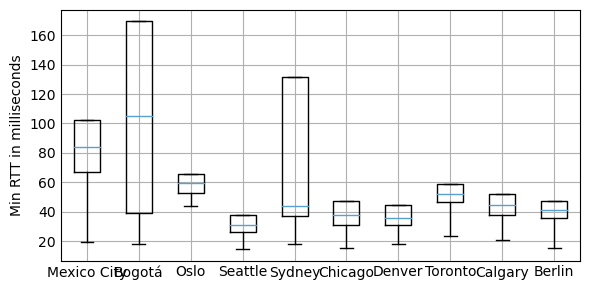

In [15]:
# 2021 - 2022
visualize_boxplot(df, "MinRTT", save=True, usestd=False)

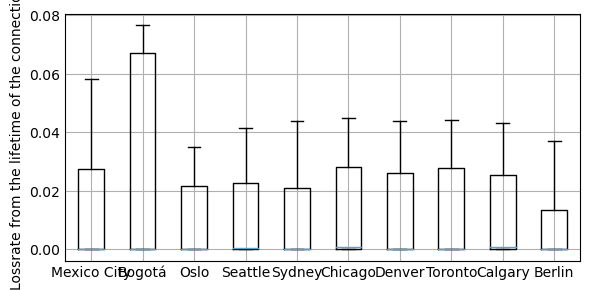

In [16]:
visualize_boxplot(df, "lossrate", save=True)